By Drilon & Chia-Hua

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow.keras as keras

2024-05-14 15:57:19.005231: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
def read_vocabulary_from_file ( filename ):
    with open(filename , 'r', encoding ="ISO−8859−1") as f:
        content = f.readlines () # content is a list of lines
        content = [x.strip () for x in content if x[0].isalnum()] # removing newline chars
        
    return content

In [14]:
positive = read_vocabulary_from_file("data/opinion-lexicon-English/positive-words.txt")
negative = read_vocabulary_from_file("data/opinion-lexicon-English/negative-words.txt")
print(len(positive), len(negative))

2006 4783


In [25]:
def load_glove_embeddings (path):
    embeddings = {}
    with open(path , 'r', encoding ='utf−8') as f:
        for line in f:
            values = line.strip ().split ()
            w = values[0]
            vectors = np. asarray (values[1:], dtype='float32')
            embeddings[w] = vectors
    return embeddings

In [28]:
word_dict = load_glove_embeddings("data/glove.6B.100d.txt")
word = "affirmative"
vector = word_dict.get(word)
print(len(vector))

100


In [40]:
def prepare_data(pos_samples, neg_samples, word_dict, embedding_dim, num_samples):
    print(len(pos_samples), len(neg_samples))
    X = np.zeros((2 * num_samples, embedding_dim))
    Y = np.zeros((2 * num_samples, 2))

    for i in range(num_samples):
        X[i] = word_dict.get(pos_samples[i], np.zeros(embedding_dim))
        Y[i] = [1.0, 0.0]  # Positive label

        X[num_samples + i] = word_dict.get(neg_samples[i], np.zeros(embedding_dim))
        Y[num_samples + i] = [0.0, 1.0]  # Negative label

    return X, Y

In [56]:
embedding_dim = 100
num_samples = 1800

random.shuffle(positive)
random.shuffle(negative)

positive_train = positive[:num_samples]
negative_train = negative[:num_samples]

positive_test = positive[num_samples:]
negative_test = negative[num_samples:]

X_train, Y_train = prepare_data(positive_train, negative_train, word_dict, embedding_dim, num_samples)

train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
Y_train = Y_train[train_indices]


num_samples_min = min(len(positive_test), len(negative_test))
positive_test = positive[num_samples:num_samples+num_samples_min]
negative_test = negative[num_samples:num_samples+num_samples_min]
X_test, Y_test = prepare_data(positive_test, negative_test, word_dict, embedding_dim, num_samples_min)

test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
Y_test = Y_test[test_indices]

print("Training data shapes: ", X_train.shape, Y_train.shape)
print("Testing data shapes: ", X_test.shape, Y_test.shape)

1800 1800
206 206
Training data shapes:  (3600, 100) (3600, 2)
Testing data shapes:  (412, 100) (412, 2)


In [57]:
model = keras.Sequential()
model.add(keras.layers.Dense(128, activation='relu', input_shape=(embedding_dim,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(64, activation='relu', input_shape=(embedding_dim,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 128)               12928     
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 64)               

In [58]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
log = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/100
113/113 [==============================] - 3s 10ms/step - loss: 0.5637 - accuracy: 0.7328 - val_loss: 0.4165 - val_accuracy: 0.8398
Epoch 2/100
113/113 [==============================] - 1s 8ms/step - loss: 0.3846 - accuracy: 0.8250 - val_loss: 0.3477 - val_accuracy: 0.8374
Epoch 3/100
113/113 [==============================] - 1s 8ms/step - loss: 0.3276 - accuracy: 0.8492 - val_loss: 0.3319 - val_accuracy: 0.8519
Epoch 4/100
113/113 [==============================] - 1s 8ms/step - loss: 0.2986 - accuracy: 0.8633 - val_loss: 0.3263 - val_accuracy: 0.8665
Epoch 5/100
113/113 [==============================] - 1s 8ms/step - loss: 0.2824 - accuracy: 0.8719 - val_loss: 0.3322 - val_accuracy: 0.8568
Epoch 6/100
113/113 [==============================] - 1s 7ms/step - loss: 0.2499 - accuracy: 0.8831 - val_loss: 0.3400 - val_accuracy: 0.8519
Epoch 7/100
113/113 [==============================] - 1s 7ms/step - loss: 0.2486 - accuracy: 0.8900 - val_loss: 0.3410 - val_accuracy: 0.854

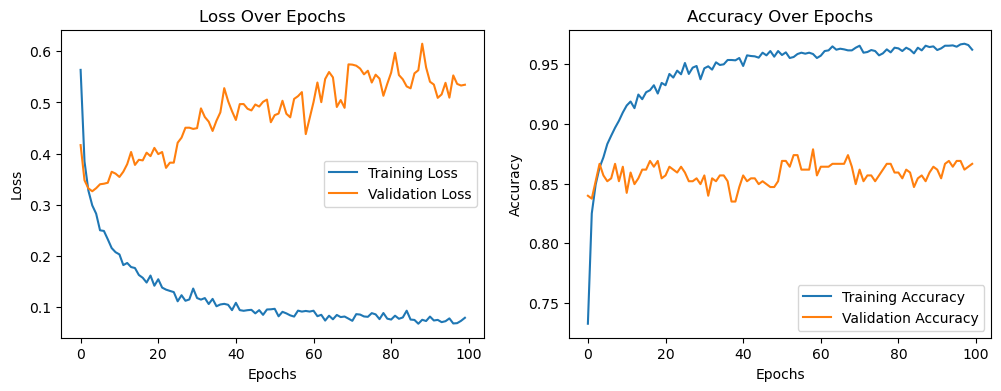

In [59]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(log.history['loss'], label='Training Loss')
plt.plot(log.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(log.history['accuracy'], label='Training Accuracy')
plt.plot(log.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [61]:
model = keras.Sequential()
model.add(keras.layers.Dense(64, activation='tanh', input_shape=(embedding_dim,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128, activation='tanh', input_shape=(embedding_dim,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(64, activation='tanh', input_shape=(embedding_dim,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(32, activation='tanh'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
log = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                6464      
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 128)              

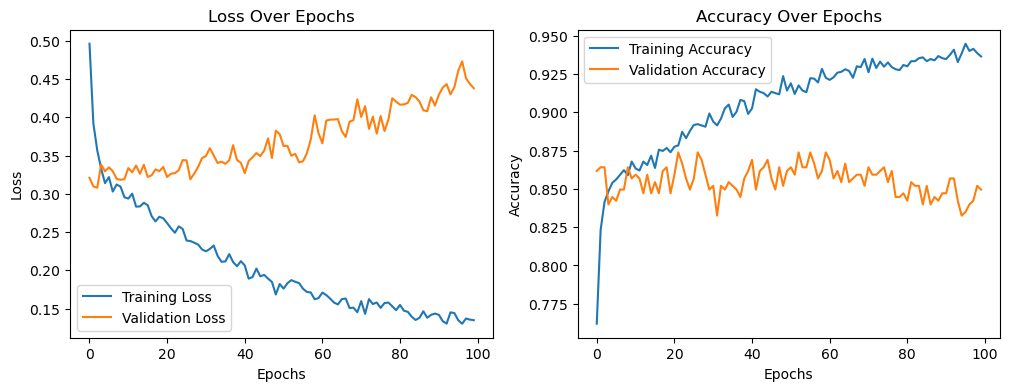

In [62]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(log.history['loss'], label='Training Loss')
plt.plot(log.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(log.history['accuracy'], label='Training Accuracy')
plt.plot(log.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [63]:
model = keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_shape=(embedding_dim,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.))
model.add(keras.layers.Dense(128, activation='relu', input_shape=(embedding_dim,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64, activation='relu', input_shape=(embedding_dim,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128, activation='relu', input_shape=(embedding_dim,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64, activation='relu', input_shape=(embedding_dim,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
log = model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_data=(X_test, Y_test))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                6464      
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 128)               8320      
                                                                 
 batch_normalization_8 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_14 (Dropout)        (None, 128)              

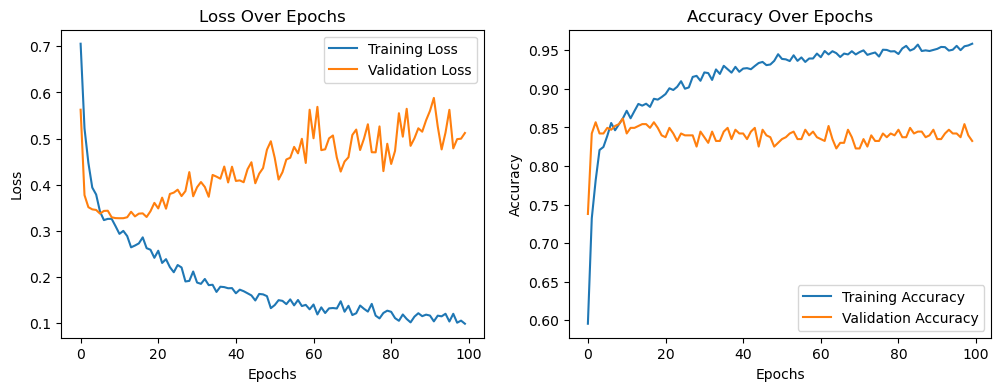

In [64]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(log.history['loss'], label='Training Loss')
plt.plot(log.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(log.history['accuracy'], label='Training Accuracy')
plt.plot(log.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [67]:
# New words for prediction including some weird gen z stuff
new_words = ["perplexing", "lol", "flabbergasting", "blue", "low", "awful", "yikes", "drip", "salty", "sus", "haha", "yoinks"]

new_word_vectors = np.array([word_dict.get(word, np.zeros(embedding_dim)) for word in new_words])

predictions = model.predict(new_word_vectors)

for word, pred in zip(new_words, predictions):
    print(f"Word: {word}, Prediction: {pred}, Class: {'Positive' if pred[0] > pred[1] else 'Negative'}")


1/1 [==============================] - 0s 40ms/step
Word: perplexing, Prediction: [9.7196382e-05 9.9990284e-01], Class: Negative
Word: lol, Prediction: [5.4603227e-04 9.9945396e-01], Class: Negative
Word: flabbergasting, Prediction: [0.02411817 0.9758818 ], Class: Negative
Word: blue, Prediction: [9.991009e-01 8.991478e-04], Class: Positive
Word: low, Prediction: [0.24435252 0.75564754], Class: Negative
Word: awful, Prediction: [0.00234403 0.997656  ], Class: Negative
Word: yikes, Prediction: [2.9990574e-07 9.9999964e-01], Class: Negative
Word: drip, Prediction: [0.26790565 0.73209435], Class: Negative
Word: salty, Prediction: [0.8983503  0.10164974], Class: Positive
Word: sus, Prediction: [0.9987814  0.00121864], Class: Positive
Word: haha, Prediction: [0.3207229 0.6792771], Class: Negative
Word: yoinks, Prediction: [0.382007   0.61799306], Class: Negative


In [72]:
clear_predictions = []
uncertain_predictions = []

for word, pred in zip(new_words, predictions):
    if pred[0] > 0.7 or pred[1] > 0.7:
        clear_predictions.append((word, pred))
    elif 0.3 <= pred[0] <= 0.7 or 0.3 <= pred[1] <= 0.7:
        uncertain_predictions.append((word, pred))

print("Clear Predictions:")
for word, pred in clear_predictions:
    print(f"Word: {word}, Prediction: {pred}, Class: {'Positive' if pred[0] > pred[1] else 'Negative'}")

print("\nUncertain Predictions:")
for word, pred in uncertain_predictions:
    print(f"Word: {word}, Prediction: {pred}, Class: {'Positive' if pred[0] > pred[1] else 'Negative'}")


Clear Predictions:
Word: perplexing, Prediction: [9.7196382e-05 9.9990284e-01], Class: Negative
Word: lol, Prediction: [5.4603227e-04 9.9945396e-01], Class: Negative
Word: flabbergasting, Prediction: [0.02411817 0.9758818 ], Class: Negative
Word: blue, Prediction: [9.991009e-01 8.991478e-04], Class: Positive
Word: low, Prediction: [0.24435252 0.75564754], Class: Negative
Word: awful, Prediction: [0.00234403 0.997656  ], Class: Negative
Word: yikes, Prediction: [2.9990574e-07 9.9999964e-01], Class: Negative
Word: drip, Prediction: [0.26790565 0.73209435], Class: Negative
Word: salty, Prediction: [0.8983503  0.10164974], Class: Positive
Word: sus, Prediction: [0.9987814  0.00121864], Class: Positive

Uncertain Predictions:
Word: haha, Prediction: [0.3207229 0.6792771], Class: Negative
Word: yoinks, Prediction: [0.382007   0.61799306], Class: Negative


The model achieved a test accuracy of around 85%, which indicates good performance for word polarity classification. Training and validation loss and accuracy plots show effective learning without significant overfitting.
Clear Predictions:

The model was confident in its predictions for the following words (probabilities close to 0 or 1):

    perplexing: Prediction: [0.000097 0.999903], Class: Negative
    lol: Prediction: [0.000546 0.999454], Class: Negative
    flabbergasting: Prediction: [0.024118 0.975882], Class: Negative
    blue: Prediction: [0.999101 0.000899], Class: Positive
    low: Prediction: [0.244353 0.755648], Class: Negative
    awful: Prediction: [0.002344 0.997656], Class: Negative
    yikes: Prediction: [0.000000 1.000000], Class: Negative
    drip: Prediction: [0.267906 0.732094], Class: Negative
    salty: Prediction: [0.898350 0.101650], Class: Positive
    sus: Prediction: [0.998781 0.001219], Class: Positive

These predictions align with expected connotations. For instance, "awful" and "yikes" are clearly negative, while "blue" and "salty" are positive. Even tough some rather new words like "salty", in the context of interaction between people, should be classified as negative as well as "sus".
Uncertain Predictions:

The model showed uncertainty for the following words (probabilities in the range [0.4-0.6]):

    haha: Prediction: [0.320723 0.679277], Class: Negative
    yoinks: Prediction: [0.382007 0.617993], Class: Negative

These modern or informal terms may not be well-represented in the training set, leading to ambiguity in predictions.

Therefore the model effectively classifies words with clear positive or negative connotations but struggles with modern slang and informal expressions. Enhancing the training dataset with contemporary terms and using contextual embeddings could improve performance, especially for nuanced language.